## Exploratory data analysis 

This notebook is meant to explore the well test data

In [24]:
#import packages
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from agents.utils.utils import make_plot_2y, make_plot
from scipy.optimize import curve_fit


In [41]:
#Load data - cheetah-20 as example
df = pd.read_excel('data/RMO_Agentic AI_train_test.xlsx', sheet_name='cheetah-90')

if "WellName" in df.columns:
    df = df.rename(columns={"WellName": "Well Name"})


In [42]:
df = df[['Date', 'Well Name', 'WT LIQ', 'WT Oil', 'WT THP', 'WT WCT', 'Z1 BHP',
       'Z2 BHP', 'Z3 BHP', 'Delta Liquid', 'Delta Oil', 'Delta THP',
       'Delta WCT', 'Delta Z1 BHP', 'Delta Z2 BHP', 'Delta Z3BHP',
       'Decline Curve', 'Zonal Configuration', 'Engineer Interp',
       'Engineer Action', 'Notification']]

In [43]:
len(df)

49

In [44]:
df.head(3)

,Date,Well Name,WT LIQ,WT Oil,WT THP,WT WCT,Z1 BHP,Z2 BHP,Z3 BHP,Delta Liquid,...,Delta THP,Delta WCT,Delta Z1 BHP,Delta Z2 BHP,Delta Z3BHP,Decline Curve,Zonal Configuration,Engineer Interp,Engineer Action,Notification
0,2023-03-26,cheetah-90,8491.442739,6717.071040,112.763133,2085.0,7400,7410,7090,0.000000,...,0.000000,0.0,0,0,0,Initial data,Commingle Production,Production Start,No Action - Keep Monitor,Well Test Result
1,2023-03-27,cheetah-90,8246.695122,7148.919424,117.076653,1330.0,7210,7220,6880,-244.747618,...,4.313520,-755.0,-190,-190,-210,NaN,NaN,NaN,NaN,NaN
2,2023-03-28,cheetah-90,8106.288357,7279.446945,116.470646,1020.0,7110,7120,6770,-140.406764,...,-0.606007,-310.0,-100,-100,-110,NaN,NaN,NaN,NaN,NaN


In [45]:
# Generate the mean value of the BHP across the zones
df['mean_bhp'] =  df[['Z1 BHP', 'Z2 BHP', 'Z3 BHP']].mean(axis=1)
df['log_diff_z1bhp_meanbhp'] = np.log(df['Z1 BHP'] / df['mean_bhp'])
df['log_diff_z2bhp_meanbhp'] = np.log(df['Z2 BHP'] / df['mean_bhp'])
df['log_diff_z3bhp_meanbhp'] = np.log(df['Z3 BHP'] / df['mean_bhp'])
df['log_diff_z1bhp'] = np.log(df['Z1 BHP'] / df['Z1 BHP'].shift(1))
df['log_diff_z2bhp'] = np.log(df['Z2 BHP'] / df['Z2 BHP'].shift(1))
df['log_diff_z3bhp'] = np.log(df['Z3 BHP'] / df['Z3 BHP'].shift(1))

In [46]:
fig_bhp_z1 = px.histogram(df, x='log_diff_z1bhp', nbins=50, title='Z1 BHP Log Difference Histogram')
fig_bhp_z1.show()

In [47]:
fig = px.histogram(df, x='log_diff_z1bhp_meanbhp', color='Engineer Interp', nbins=100, height=600, width = 1200, hover_data='WT Oil', title = f'Log diff z1bhp vs mean bhp: cheetah-20 Zone 1')
fig.show()

In [48]:
fig = px.histogram(df, x='log_diff_z1bhp_meanbhp', color='Zonal Configuration', nbins=100, height=600, width = 1200, hover_data='WT Oil', title = f'Log diff z1bhp vs mean bhp: cheetah-20 Zone 1')
fig.show()

In [49]:
fig = px.histogram(df, x='log_diff_z2bhp_meanbhp', color='Engineer Interp', nbins=100, height=600, width = 1200, hover_data='WT Oil', title = f'Log diff z1bhp vs mean bhp: cheetah-20 Zone 2')
fig.show()

In [50]:
fig = px.histogram(df, x='log_diff_z2bhp_meanbhp', color='Zonal Configuration', nbins=100, height=600, width = 1200, hover_data='WT Oil', title = f'Log diff z1bhp vs mean bhp: cheetah-20 Zone 2')
fig.show()

In [51]:
fig = px.histogram(df, x='log_diff_z3bhp_meanbhp', color='Engineer Interp', nbins=100, height=600, width = 1200, hover_data='WT Oil', title = f'Log diff z1bhp vs mean bhp: cheetah-20 Zone 3')
fig.show()

In [52]:
fig = px.histogram(df, x='log_diff_z3bhp_meanbhp', color='Zonal Configuration', nbins=100, height=600, width = 1200, hover_data='WT Oil', title = f'Log diff z1bhp vs mean bhp: cheetah-20 Zone 3')
fig.show()

In [53]:
#Convert date to datetime
df['Date'] = pd.to_datetime(df['Date'])
df.set_index(df['Date'], inplace=True)

        
#Select well test columns
df_subset = df[['Date', 'WT LIQ', 'WT THP', 'WT WCT', 'WT GL', 'WT Oil']].copy()
df_subset.dropna(inplace = True)
df_subset_og = df_subset.copy()


#Remove outliers
df_subset, index_list = remove_outliers(df_subset)

KeyError: "['WT GL'] not in index"

In [ ]:
df_subset = df_subset.loc[index_list].copy()

<Axes: xlabel='Date'>

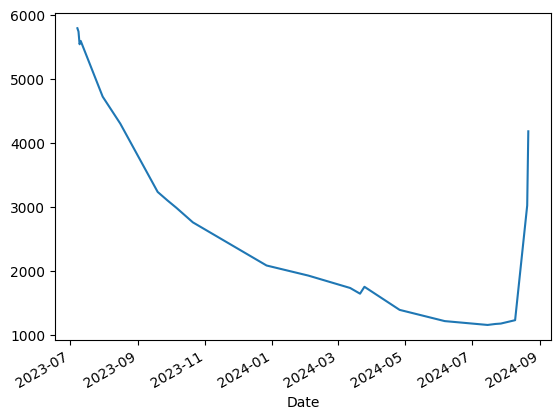

In [ ]:
df_subset['WT Oil'].plot()

In [ ]:
# Function to fit the decline curve
def fit_decline_curve(data, time_col, rate_col, auto = True, qi = None, Di = None, type = 'exponential'):
    # Extract time and rate data
    t = data[time_col]
    q = data[rate_col]

    # Define the exponential decline function
    def exponential_decline(t, qi, Di):
        return qi * np.exp(-Di * t)

    #Define the hyperbolic decline function
    def hyperbolic_decline(t, qi, b, Di):
        return qi/((1.0+b*Di*t)**(1.0/b))
    
    if auto == True:
        if type == 'hyperbolic':

            # Initial guesses for the parameters
            qi_initial = 8000 # Example initial guess for qi
            b_initial = 0.5 # Example initial guess for b
            Di_initial = 0.05 # Example initial guess for Di

            # Bounds for the parameters
            qi_max = 9000 # Example maximum value for qi
            b_max = 1.0 # Example maximum value for b
            Di_max = 0.2 # Example maximum value for Di

            # Fit the hyperbolic decline curve
            popt, _ = curve_fit(hyperbolic_decline, t, q, 
                                p0=[qi_initial, b_initial, Di_initial],
                                bounds=(0, [qi_max, b_max, Di_max]),
                                maxfev=100000)

            # Generate fitted values
            q_fit = hyperbolic_decline(t, *popt)

        elif type == 'exponential':
            # Fit the exponential decline curve
            popt, _ = curve_fit(exponential_decline, t, q, maxfev=10000)

            # Extract fitted parameters
            qi, Di = popt

            # Generate fitted values
            q_fit = exponential_decline(t, qi, Di)
        else:
            raise ValueError("Invalid type. Choose 'exponential' or 'hyperbolic'.")
    else: #Define the parameters manually
        qi = 6000
        Di = 0.008
        q_fit = exponential_decline(t, qi, Di)
    
    # Return fitted parameters and values
    return q_fit

# Fit the decline recursively
def recursive_fit(data, time_col, rate_col, auto = True, qi = None, Di = None, type_ = 'hyperbolic'):
    # Initialize lists to store fitted parameters and values
    q_fit_list = []

    # Loop through the data in chunks
    for i in range(4, len(data)+1):
        chunk = data.tail(i)
        chunk[time_col] = (chunk['Date'] - chunk['Date'].min()).dt.days
        q_fit = fit_decline_curve(chunk, time_col, rate_col, auto, qi, Di, type=type_)
        
        # Append fitted values and values to the lists
        q_fit_list.append(q_fit)

    return q_fit_list

### Testing recursive DCA fitting

In [ ]:
#try the recursive fit
df_subset_24 = df_subset[df_subset['Date'] < '2024-08-01'].copy()
q_fit_list = recursive_fit(df_subset_24, 'Days', 'WT Oil', auto = True, type_ = 'hyperbolic')

/tmp/ipykernel_2399/211786757.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk[time_col] = (chunk['Date'] - chunk['Date'].min()).dt.days
/tmp/ipykernel_2399/211786757.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk[time_col] = (chunk['Date'] - chunk['Date'].min()).dt.days
/tmp/ipykernel_2399/211786757.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

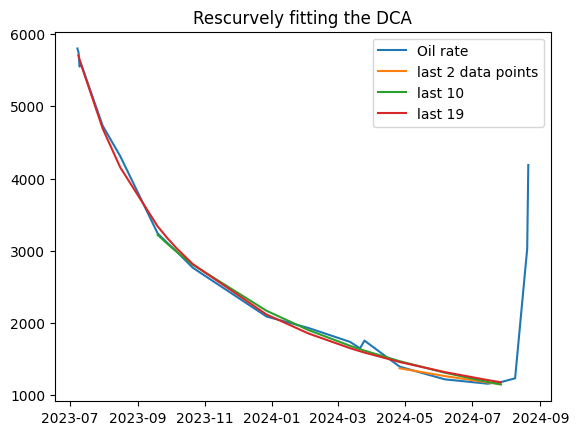

In [ ]:
import matplotlib.pyplot as plt
#plt.plot(q_fit)
plt.plot(df_subset['WT Oil'])
plt.plot(q_fit_list[1])
plt.plot(q_fit_list[10])
plt.plot(q_fit_list[15])

plt.title('Rescurvely fitting the DCA')
plt.legend(['Oil rate', 'last 2 data points', 'last 10', 'last 19', 'last 25', 'All'])

######################################
# Conclusion: This method does not work
######################################


### Testing Polynomial regression

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Fit the decline recursively
def poly_fit(data, time_col, rate_col):
    # Initialize lists to store fitted parameters and values
    prediction = []

    # Loop through the data in chunks
    for i in range(4, len(data)+1, 4):
        chunk = data.iloc[0:i]
        chunk[time_col] = (chunk['Date'] - chunk['Date'].min()).dt.days
        x = chunk[time_col].values.reshape(-1, 1)
        y = chunk[rate_col].values.reshape(-1, 1)
        
        #Define the model
        poly_model = PolynomialFeatures(degree=4)
        x_poly = poly_model.fit_transform(x)
        lr_model = LinearRegression()
        lr_model.fit(x_poly, y)

        y_pred = lr_model.predict(x_poly)
        
        chunk['poly_predicted'] = y_pred
        
        # Append fitted parameters and values to the lists
        prediction.append(chunk['poly_predicted'])

    return prediction, lr_model, poly_model

/tmp/ipykernel_2399/826072018.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk[time_col] = (chunk['Date'] - chunk['Date'].min()).dt.days
/tmp/ipykernel_2399/826072018.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['poly_predicted'] = y_pred
/tmp/ipykernel_2399/826072018.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

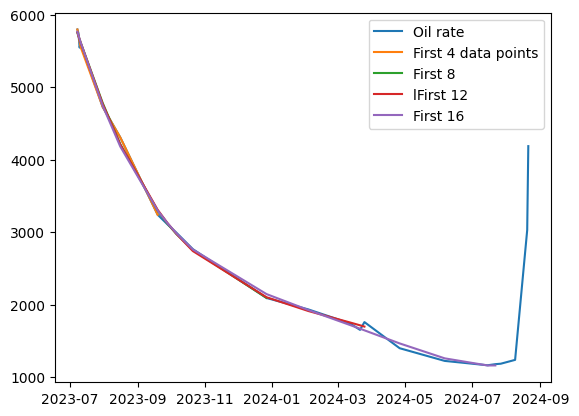

In [ ]:
import matplotlib.pyplot as plt

# Try the polynomial prediction
prediction, lr_model, poly_model = poly_fit(df_subset_24, 'Days', 'WT Oil')

#plt.plot(q_fit)
plt.plot(df_subset['WT Oil'])
plt.plot(prediction[1])
plt.plot(prediction[2])
plt.plot(prediction[3])
plt.plot(prediction[4])
#plt.plot(prediction[5])

plt.title('')
plt.legend(['Oil rate', 'First 4 data points', 'First 8', 'lFirst 12', 'First 16', 'All'])

(0.0, 7000.0)

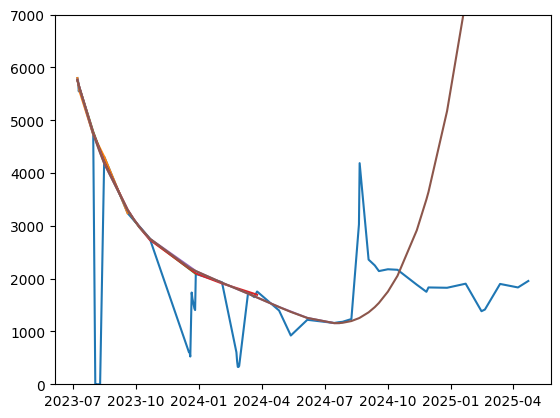

In [ ]:

# Try the polynomial prediction on future dates

#predict the future - use original dataframe
x_future = (df_subset_og['Date'] - df_subset_og['Date'].min()).dt.days
x_future = x_future.values.reshape(-1, 1)
x_future_poly = poly_model.fit_transform(x_future)
y_future = lr_model.predict(x_future_poly)

df_subset_og['poly_predicted'] = y_future

#plt.plot(q_fit)
plt.plot(df_subset_og['WT Oil'])
plt.plot(prediction[1])
plt.plot(prediction[2])
plt.plot(prediction[3])
plt.plot(prediction[4])
plt.plot(df_subset_og['poly_predicted'])
plt.ylim(0, 7000)
